# Biomimetic model of corticostriatal micro-assemblies

## Introduction
In this session we will build a neural assembly that is part of a larger model that performs category learning of images [1]. We will follow a bottom-up approach moving across three levels; from `Neuron` Blox objects to a `CompositeBlox` containing `Neuron` objects to a `CompositeBlox` containing the first `CompositeBlox`.

In a later session we will extend this model and add synaptic plasticity to it to perform category learning, as a simplified version of [1].

## Lateral Inhibition Circuit

In [1]:
import Pkg
Pkg.activate(@__DIR__)

  Activating project at `~/Desktop/Neuroblox /notebooks`


In [2]:
using Neuroblox
using OrdinaryDiffEq
using Random
using CairoMakie

Important Note: Neuroblox is a commercial product of Neuroblox, Inc.
It is free to use for non-commercial academic teaching
and research purposes. For commercial users, license fees apply.
Please refer to the End User License Agreement
(https://github.com/Neuroblox/NeurobloxEULA) for details.
Please contact sales@neuroblox.org for purchasing information.

To report any bugs, issues, or feature requests for Neuroblox software,
please use the public Github repository NeurobloxIssues, located at
https://github.com/Neuroblox/NeurobloxIssues.


First we will manually create a lateral inhibition circuit (*Figure 1*, the "winner-takes-all" circuit) to better understand its components. This circuit is inspired by the structure of the superficial cortical layer.

![Lateral inhibition in the winner-takes-all circuit](./assets/CS_WTA.png)

*Figure 1: Lateral inhibition in the winner-takes-all circuit.*

In [3]:
model_name = :g

@named inh = HHNeuronInhibBlox(namespace=model_name, G_syn = 4.0) ##feedback inhibitory interneuron neuron

##creating an array of excitatory pyramidal neurons
@named exci1 = HHNeuronExciBlox(namespace=model_name, I_bg = 5*rand())
@named exci2 = HHNeuronExciBlox(namespace=model_name, I_bg = 5*rand())
@named exci3 = HHNeuronExciBlox(namespace=model_name, I_bg = 5*rand())
@named exci4 = HHNeuronExciBlox(namespace=model_name, I_bg = 5*rand())
@named exci5 = HHNeuronExciBlox(namespace=model_name, I_bg = 5*rand())

g = MetaDiGraph()

for exci_neuron in [exci1, exci2, exci3, exci4, exci5]
    add_edge!(g, inh => exci_neuron, weight = 1)
    add_edge!(g, exci_neuron => inh, weight = 1)
end

As we can see, the lateral inhibition circuit is made up of 5 excitatory neurons with each one having a reciprocal connection to the same inhibitory interneuron.

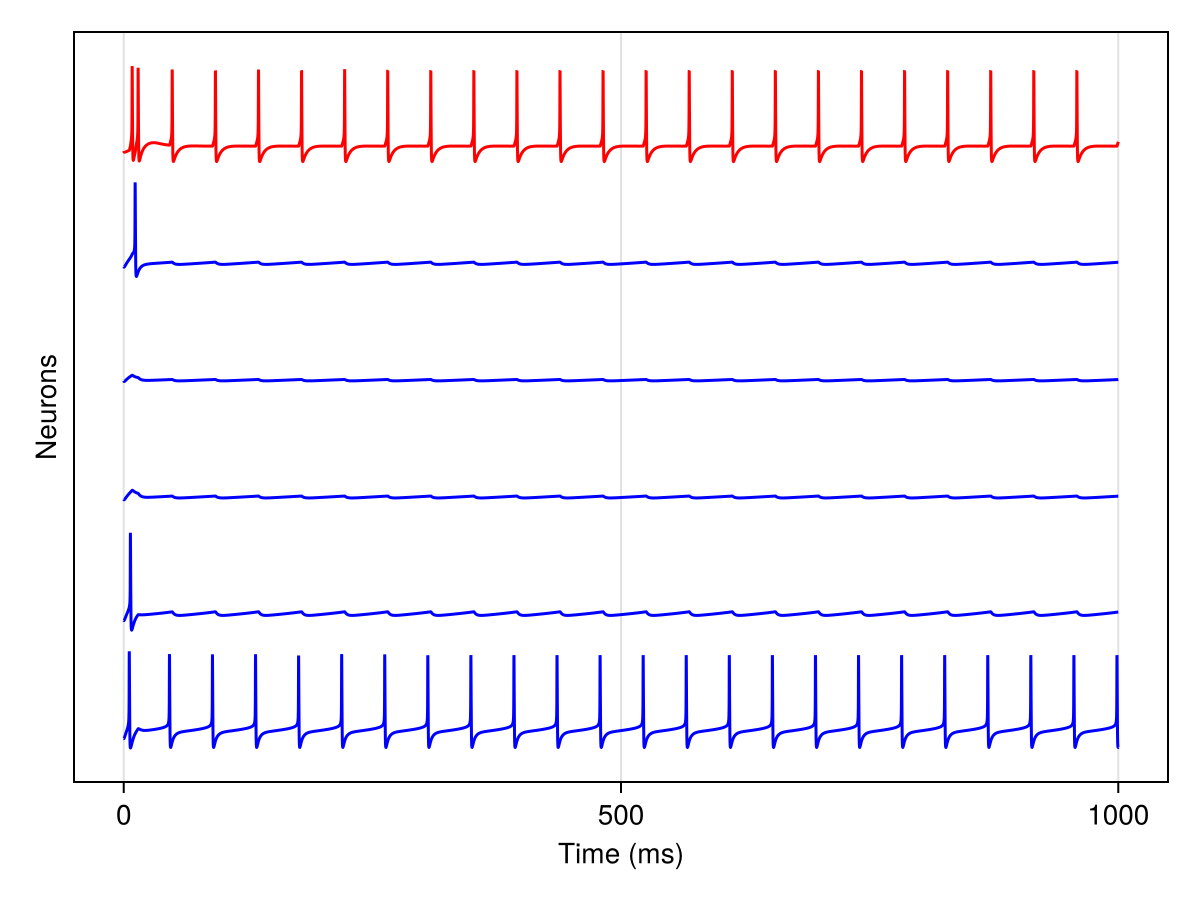

In [4]:
@named sys = system_from_graph(g)
prob = ODEProblem(sys, [], (0.0, 1000), [])
sol = solve(prob, Vern7())
fig = stackplot([exci1, exci2, exci3, exci4, exci5, inh], sol)

`stackplot` stacks the voltage timeseries of each input neuron on top of each other. Excitatory neurons appear in blue and inhibitory neurons in red by default. The y-axis scale is meaningless due to timeseries offsets, yet the plot offers a useful look into spiking patterns in a population.
> **_Exercise:_** Try varying the size of the circuit by changing the number of excitatory neurons, while keeping the same structure (all of them connect to the inhibitory neuron and vice versa).

The circuit we just built is implemented as a single Blox in Neuroblox. The `WinnerTakeAllBlox` is a subtype of `CompositeBlox`. Now we will connect two of these together using the Neuroblox strutures.

In [5]:
N_exci = 5 ## number of excitatory neurons in each WTA circuit

5

For a single-valued input `I_bg`, each neuron in the WTA Blox will receive a uniformly distributed random background current from 0 to `I_bg`.

In [6]:
@named wta1 = WinnerTakeAllBlox(namespace=model_name, I_bg=5, N_exci=N_exci)
@named wta2 = WinnerTakeAllBlox(namespace=model_name, I_bg=4, N_exci=N_exci)

g = MetaDiGraph()
add_edge!(g, wta1 => wta2, weight=1, density=0.5);

The `density` keyword argument sets the connection probability from each excitatory neuron of `wta1` to each excitatory neuron of `wta2`.
Whether a connection is actually made or not depends on a Bernoulli trial with probability of success equal to `density`.

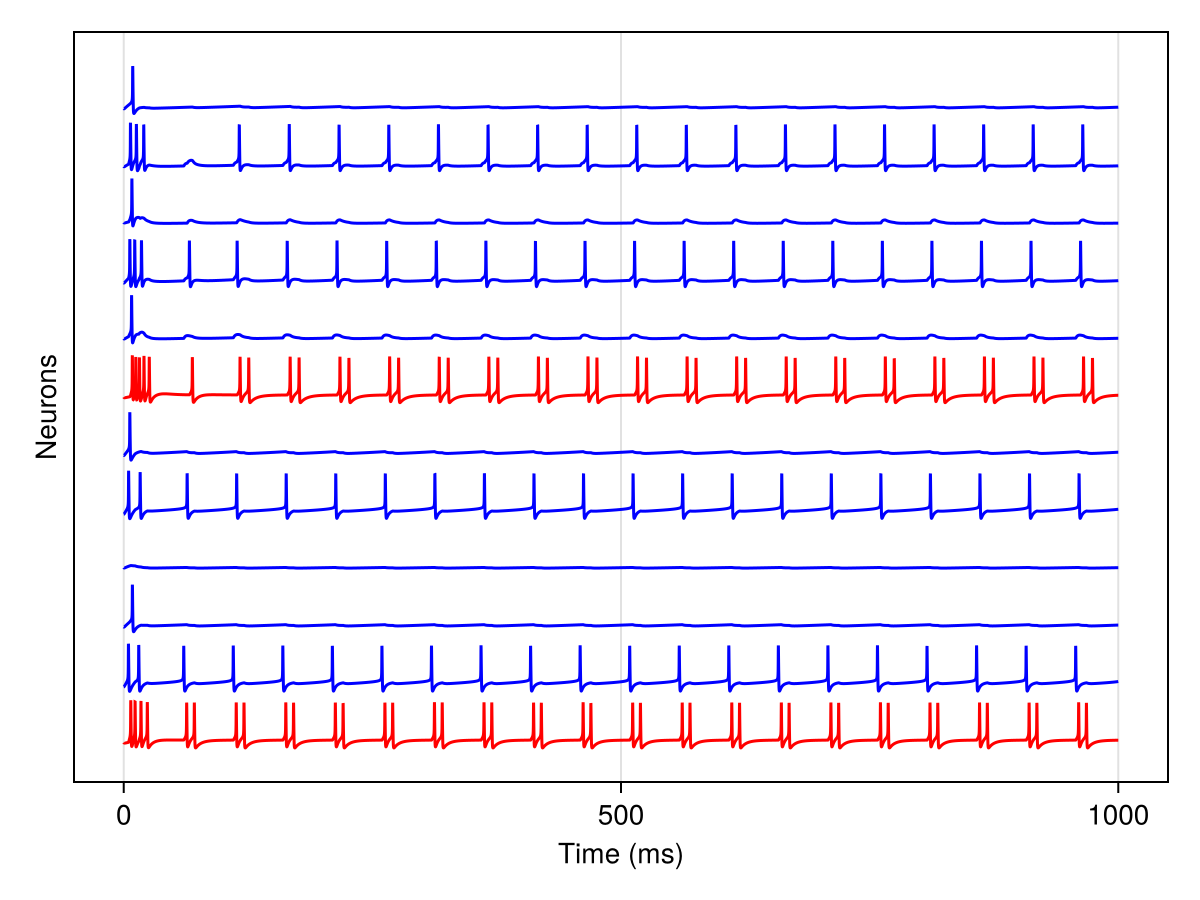

In [7]:
sys = system_from_graph(g, name=model_name)
prob = ODEProblem(sys, [], (0.0, 1000), [])
sol = solve(prob, Vern7())

neuron_set = get_neurons([wta1, wta2]) ## extract neurons from a composite blocks
fig = stackplot(neuron_set, sol)

## Cortical Superficial Layer

Now we are ready to create a single cortical superficial layer block by connecting multiple WTA circuits

This model is SCORT in [1] and looks like the one in *Figure 2*.

![Cortical circuit with multiple WTA microcircuits](./assets/CS_Cortical.png)

*Figure 2: Cortical circuit with multiple WTA microcircuits.*

In [8]:
N_wta = 10 ## number of WTA circuits

10

parameters

In [9]:
N_exci = 5   ## number of pyramidal neurons in each lateral inhibition (WTA) circuit
G_syn_exci = 3.0 ## maximal synaptic conductance in glutamatergic (excitatory) synapses
G_syn_inhib = 4.0 ## maximal synaptic conductance in GABAergic (inhibitory) synapses from feedback interneurons
G_syn_ff_inhib = 3.5 ## maximal synaptic conductance in GABAergic (inhibitory) synapses from feedforward interneurons
I_bg = 5.0 ## background input current
density = 0.01 ## connection density between WTA circuits

0.01

create a vector of `WinnerTakesAllBlox` using list comprehension

In [10]:
wtas = [WinnerTakeAllBlox(;
                        name=Symbol("wta$i"), ## manually add a name instead of using the @named macro
                        namespace=model_name,
                        N_exci=N_exci,
                        G_syn_exci=G_syn_exci,
                        G_syn_inhib=G_syn_inhib,
                        I_bg = I_bg
                        )
for i = 1:N_wta]

@named n_ff_inh = HHNeuronInhibBlox(; namespace=model_name, G_syn=G_syn_ff_inhib)

g = MetaDiGraph()

for i in 1:N_wta
    for j in 1:N_wta
        if j != i
            add_edge!(g, wtas[i] => wtas[j], weight=1, density=density);
        end
    end
    add_edge!(g, n_ff_inh => wtas[i], weight=1);
end

WTA circuits connect to each other with given connection density and the feedforward interneuron connects to each WTA circuit.
The feed-forward interneuron `n_ff_inh` receives input from the excitatory (pyramidal) cells of the WTA circuits and it is largely responsible for controlling the spiking rhythm of the ensemble of WTAs.

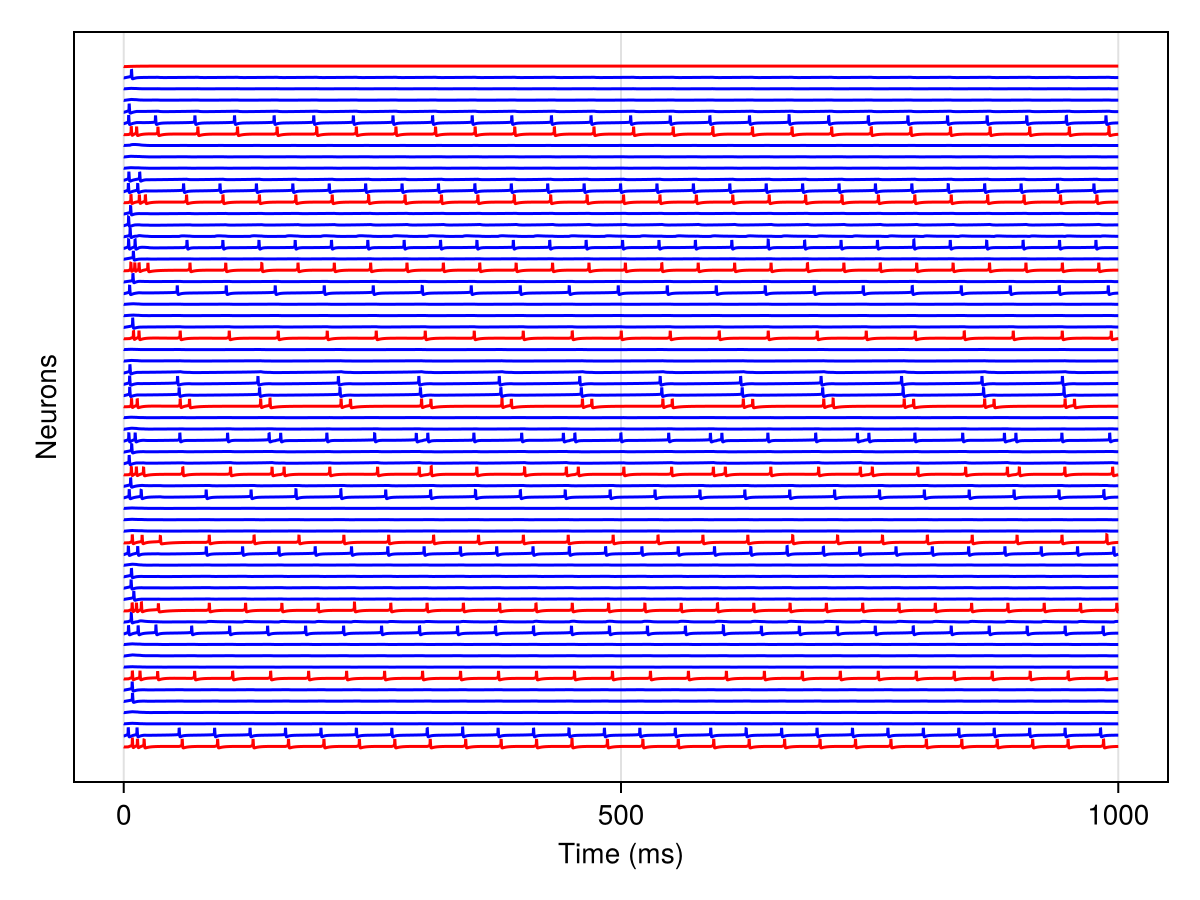

In [11]:
sys = system_from_graph(g, name = model_name)
prob = ODEProblem(sys, [], (0.0, 1000))
sol = solve(prob, Vern7())

wta_neurons = get_neurons(wtas) ## extract neurons from WTA circuits
neurons = vcat(wta_neurons, n_ff_inh)
fig = stackplot(neurons, sol)

> **_Exercise:_** Try different connection densities and weights and see how it affects the population activity.

## Cortical Superficial Layer with Ascending System

The next step is to expand the cortical model we just created by adding a Blox representing an ascending system (ASC1 in [1]) to it.
We define the ascending system using a Next Generation Neural Mass model as described in [2]. The neural mass parameters are fixed to generate a 16 Hz modulating frequency in the cortical neurons.

In [ ]:
@named ASC1 = NextGenerationEIBlox(;namespace=model_name, Cₑ=2*26, Cᵢ=26, v_synₑₑ=10.0, v_synₑᵢ=-10.0, v_synᵢₑ=10.0, v_synᵢᵢ=-10.0, alpha_invₑₑ=10.0/26, alpha_invₑᵢ=0.8/26, alpha_invᵢₑ=10.0/26, alpha_invᵢᵢ=0.8/26, kₑᵢ=0.6*26, kᵢₑ=0.6*26);

Similar to `WinnerTakeAllBlox`, the cortical model we created above by connecting multiple WTAs together is implemented as a single Blox in Neuroblox. This is the `CorticalBlox` and it models a superficial layer cortical microcircuit.
So `CorticalBlox` is a hierarchical Blox which holds a feedforward interneuron and multiple `WinnerTakeAllBlox` which in turn hold multiple excitatory neurons and one feedback interneuron each.

number if WTA circuits = N_wta=45
number of pyramidal neurons in each WTA circuit = N_exci = 5

In [ ]:
@named CB = CorticalBlox(N_wta=10, N_exci=5, density=0.01, weight=1, I_bg_ar=7; namespace=model_name)

g = MetaDiGraph()
add_edge!(g, ASC1 => CB, weight=44)

solve the system for time 0 to 1000 ms

In [ ]:
sys = system_from_graph(g, name = model_name)
prob = ODEProblem(sys, [], (0.0, 1000))
sol = solve(prob, Vern7());

neuron_set = get_neurons(CB) ## extract neurons from a composite block like CorticalBlox
n_neurons = 50 ## set number of neurons to display in the stackplot
fig = stackplot(neuron_set[1:n_neurons], sol)

We can also generate plots of averaged activity in any composite Blox like `CorticalBlox` and `WinnerTakeAllBlox`.
For instance the meanfield of all cortical block neurons (mean membrane voltage)

In [ ]:
fig = meanfield(CB, sol)

and the powerspectrum of the meanfield (average over membrane potentials)

In [ ]:
fig = powerspectrumplot(CB, sol; sampling_rate=0.01)

Notice the peak at 16 Hz, representing beta oscillations.
> **_Exercise:_** Try changing parameters of `ASC1` to generate different cortical rhythms.

## Visual Processing in the extended Cortical model

Finally we will simulate visual processing in our model by adding a `CorticalBlox` representing visual area cortex (VAC) and an `ImageStimulus` connected to it. This extended model is shown in *Figure 3*.

![Extended circuit with Cortex, Brainstem and Image Stimulus components](./assets/CS_extended.png)

*Figure 3: Extended circuit with Cortex, Brainstem and Image Stimulus components.*

In [ ]:
@named VAC = CorticalBlox(namespace=model_name, N_wta=10, N_exci=5,  density=0.01, weight=1)
@named AC = CorticalBlox(namespace=model_name, N_wta=10, N_exci=5, density=0.01, weight=1)

ascending system blox, modulating frequency set to 16 Hz

In [ ]:
@named ASC1 = NextGenerationEIBlox(namespace=model_name, Cₑ=2*26,Cᵢ=1*26, Δₑ=0.5, Δᵢ=0.5, η_0ₑ=10.0, v_synₑₑ=10.0, v_synₑᵢ=-10.0, v_synᵢₑ=10.0, v_synᵢᵢ=-10.0, alpha_invₑₑ=10.0/26, alpha_invₑᵢ=0.8/26, alpha_invᵢₑ=10.0/26, alpha_invᵢᵢ=0.8/26, kₑᵢ=0.6*26, kᵢₑ=0.6*26)

using CSV ## to read data from CSV files
using DataFrames ## to format the data into DataFrames
using Downloads ## to download image stimuli files

image_set = CSV.read(Downloads.download("raw.githubusercontent.com/Neuroblox/NeurobloxDocsHost/refs/heads/main/data/image_example.csv"), DataFrame) ## reading data into DataFrame format
image_sample = 2 ## set which image to input (from 1 to 1000)

@named stim = ImageStimulus(
    image_set[[image_sample], :],
    namespace=model_name,
    t_stimulus = 1000, ## how long the stimulus is on (in msec)
    t_pause = 0 ## how long the stimulus is off after `t_stimulus` (in msec)
);

access the desired image sample, exclude the last row that is a category label

In [ ]:
pixels = Array(image_set[image_sample, 1:end-1])

reshape into 15 X 15 square image matrix

In [ ]:
pixels = reshape(pixels, 15, 15)

plot the image that the visual cortex 'sees'

In [ ]:
fig = heatmap(pixels, colormap = :gray1)

Above we can see an example image stimulus. Each pixel of the image stimulus is a variable (`stim₊u_i`) that connects to a neuron of the visual cortex `VAC` Blox. Using `connection_rule(stim, VAC)` we can better see how this connection is implemented.

In [ ]:
g = MetaDiGraph()
add_edge!(g, stim => VAC, weight=14)
add_edge!(g, ASC1 => VAC, weight=44)
add_edge!(g, ASC1 => AC, weight=44)
add_edge!(g, VAC => AC, weight=3, density=0.08)

define system and solve

In [ ]:
sys = system_from_graph(g, name=model_name)
prob = ODEProblem(sys, [], (0.0, 1000))
sol = solve(prob, Vern7());

> **_Exercise:_** : Use the plotting functions from above to visualize the simulation results for any Blox of your choice.
> Try changing the image samples and notice the change in the spatial firing patterns in VAC and AC neurons.

## Challenge Problems
- Try changing parameters of ASC1, which is modeled as Next Generation Neural Mass Model to generate different cortical rhythms. See how the peak shifts in the power spectrum when you connect AC1 to a cortical block CB. Currently it’s set for 16 hz oscillation. See if you can get it to oscillate at 5 Hz, 10 Hz and 20 Hz.
- In the circuit with ASC1, VAC, AC and stimuli, add another ascending input ‘ASC2’ such that ASC1 connects only to VAC and ASC2 connects only to AC. Now set the parameters of ASC2 to oscillate at different frequencies (5 Hz, 10 Hz etc.). Observe the power spectrum of the activity of AC, does it show two peaks?
- Try different values of t_stimulus and t_pause that are set during defining the stimulus (such that t_stimulus + t_pause = 1000 msec). See the effect in the activities of VAC and AC in their stack plots. You will notice that the activity in the cortical blocks stops after t=t_stimulus. Now try making multiple cortical blocks similar to AC (AC1, AC2 say). Try connecting them in different topologies. One possibility is a chain i.e VAC -> AC1 -> AC2 … so on. Another possibility is of a loop i.e. VAC -> AC1 -> AC2 …. -> AC1. In this loop, the activity can sustain even in the absence of stimulus (during t_pause) due to the feedback loop. Try and see if you can create a loop where activity persists even after t=t_stimulus.

## References
- [1] Pathak A., Brincat S., Organtzidis H., Strey H., Senneff S., Antzoulatos E., Mujica-Parodi L., Miller E., Granger R. Biomimetic model of corticostriatal micro-assemblies discovers new neural code., bioRxiv 2023.11.06.565902, 2024
- [2] Byrne Á, O'Dea RD, Forrester M, Ross J, Coombes S. Next-generation neural mass and field modeling. J Neurophysiol. 2020 Feb 1;123(2):726-742. doi: 10.1152/jn.00406.2019. Epub 2019 Nov 27. PMID: 31774370.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*